# Creative GTM: Why One Message Shouldn’t Fit Everyone

This notebook explores customer behavior from historical marketing campaigns
and motivates a **persona-driven, AI-assisted GTM system** for creative generation.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("marketing_campaign.csv", sep=";")
print(df.shape)
df.head()


(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [11]:
#Missing values

df.isna().sum().sort_values(ascending=False).head(10)

Income               24
ID                    0
NumDealsPurchases     0
Z_Revenue             0
Z_CostContact         0
Complain              0
AcceptedCmp2          0
AcceptedCmp1          0
AcceptedCmp5          0
AcceptedCmp4          0
dtype: int64

In [13]:
df["Year_Birth"].describe()

count    2240.000000
mean     1968.805804
std        11.984069
min      1893.000000
25%      1959.000000
50%      1970.000000
75%      1977.000000
max      1996.000000
Name: Year_Birth, dtype: float64

In [ ]:
df["Income"].describe()

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64

In [15]:
accepted_cols = [
    "AcceptedCmp1","AcceptedCmp2","AcceptedCmp3",
    "AcceptedCmp4","AcceptedCmp5"
]

df["past_accept_count"] = df[accepted_cols].sum(axis=1)
df["responded_last_campaign"] = df["Response"]
df["responded_any_campaign"] = (
    (df["past_accept_count"] > 0) | (df["Response"] == 1)
).astype(int)

In [16]:
spend_cols = [
    "MntWines","MntFruits","MntMeatProducts",
    "MntFishProducts","MntSweetProducts","MntGoldProds"
]

df["total_spend"] = df[spend_cols].sum(axis=1)
df["total_spend"].describe()


count    2240.000000
mean      605.798214
std       602.249288
min         5.000000
25%        68.750000
50%       396.000000
75%      1045.500000
max      2525.000000
Name: total_spend, dtype: float64

In [17]:
def assign_cohort(year):
    if year >= 1988:
        return "Young Professionals"
    elif 1976 <= year <= 1987:
        return "Mid-Career"
    elif 1965 <= year <= 1975:
        return "Established"
    else:
        return "Legacy"

df["cohort"] = df["Year_Birth"].apply(assign_cohort)
df["cohort"].value_counts()

cohort
Legacy                 786
Established            759
Mid-Career             575
Young Professionals    120
Name: count, dtype: int64

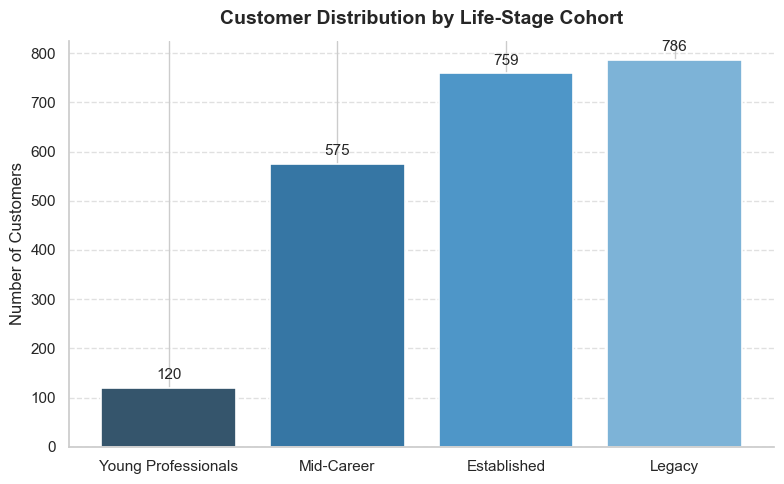

In [21]:
# Presentation-style: Customer distribution by cohort
cohort_order = ["Young Professionals", "Mid-Career", "Established", "Legacy"]
counts = df["cohort"].value_counts().reindex(cohort_order).dropna()

fig, ax = plt.subplots(figsize=(8, 5))
colors = sns.color_palette("Blues_d", n_colors=len(counts))[::-1]
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor="white", linewidth=1.2)

ax.set_ylabel("Number of Customers", fontsize=12, fontweight="medium")
ax.set_xlabel("")
ax.set_title("Customer Distribution by Life-Stage Cohort", fontsize=14, fontweight="bold", pad=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)

for bar in bars:
    h = bar.get_height()
    ax.annotate(f"{int(h):,}", xy=(bar.get_x() + bar.get_width() / 2, h),
                xytext=(0, 4), textcoords="offset points", ha="center", va="bottom",
                fontsize=11, fontweight="medium")
plt.xticks(rotation=0, ha="center")
plt.tight_layout()
plt.show()


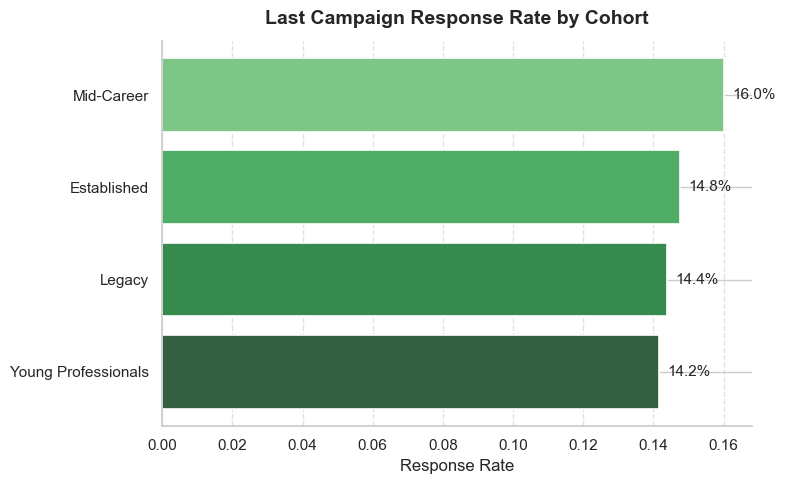

In [20]:
# Presentation-style: Response rate by cohort
cohort_order = ["Young Professionals", "Mid-Career", "Established", "Legacy"]
rates = df.groupby("cohort")["responded_last_campaign"].mean().reindex(cohort_order).dropna()
rates = rates.sort_values(ascending=True)  # ascending so highest bar on right for readability

fig, ax = plt.subplots(figsize=(8, 5))
colors = sns.color_palette("Greens_d", n_colors=len(rates))[::-1]
bars = ax.barh(rates.index, rates.values, color=colors, edgecolor="white", linewidth=1.2)

ax.set_xlabel("Response Rate", fontsize=12, fontweight="medium")
ax.set_title("Last Campaign Response Rate by Cohort", fontsize=14, fontweight="bold", pad=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.xaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)
ax.set_xlim(0, None)

for bar in bars:
    w = bar.get_width()
    ax.annotate(f"{w:.1%}", xy=(w, bar.get_y() + bar.get_height() / 2),
                xytext=(6, 0), textcoords="offset points", ha="left", va="center",
                fontsize=11, fontweight="medium")
plt.tight_layout()
plt.show()


In [22]:
df["past_accept_count"].value_counts().head(10)
def assign_persona(row, spend_med, engage_med):
    high_spend = row["total_spend"] >= spend_med
    high_engage = row["past_accept_count"] >= engage_med

    if high_spend and high_engage:
        return "Champions"
    if high_spend and not high_engage:
        return "Premium-but-Quiet"
    if not high_spend and high_engage:
        return "Deal-Responsive"
    return "Hard-to-Convert"


In [23]:
df["persona"] = None

for cohort, g in df.groupby("cohort"):
    spend_med = g["total_spend"].median()
    engage_med = g["past_accept_count"].median()

    idx = g.index
    df.loc[idx, "persona"] = g.apply(
        assign_persona,
        axis=1,
        spend_med=spend_med,
        engage_med=max(engage_med, 1)
    )


In [24]:
pd.crosstab(df["cohort"], df["persona"])


persona,Champions,Deal-Responsive,Hard-to-Convert,Premium-but-Quiet
cohort,,,,
Established,110,34,343,272
Legacy,138,43,350,255
Mid-Career,85,24,262,204
Young Professionals,24,5,55,36
